In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from category_encoders import BinaryEncoder
from category_encoders import OneHotEncoder

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.set(style="whitegrid")

In [3]:
train_set_original = pd.read_csv("train.csv", index_col = "PassengerId")
test_set_original = pd.read_csv("test.csv", index_col = "PassengerId")


Com os dados carregados vamos descobrir que _features_ o nosso conjunto de testes oferece.

In [4]:
train_set_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Por curiosidade, vamos exibir a subrevivência entre homens e mulheres por classe. Nota-se que proporcionalmente em todas as classes as mulheres sobreviveram mais.

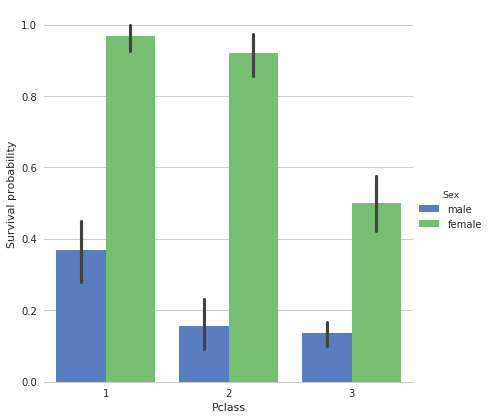

In [5]:
# https://seaborn.pydata.org/examples/factorplot_bars.html
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train_set_original, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Survival probability")
plt.show()

União dos dados de treinamento e de teste para o tratamento de valores faltantes.

In [6]:
complete_set = pd.concat([train_set_original, test_set_original], keys = ["train", "test"])
complete_set.head()

Age Cabin Embarked     Fare  \
      PassengerId                                 
train 1            22.0   NaN        S   7.2500   
      2            38.0   C85        C  71.2833   
      3            26.0   NaN        S   7.9250   
      4            35.0  C123        S  53.1000   
      5            35.0   NaN        S   8.0500   

                                                                Name  Parch  \
      PassengerId                                                             
train 1                                      Braund, Mr. Owen Harris      0   
      2            Cumings, Mrs. John Bradley (Florence Briggs Th...      0   
      3                                       Heikkinen, Miss. Laina      0   
      4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)      0   
      5                                     Allen, Mr. William Henry      0   

                   Pclass     Sex  SibSp  Survived            Ticket  
      PassengerId                                                     
train 1                 3    male      1       0.0         A/5 21171  
      2                 1  female      1       1.0          PC 17599  
      3                 3  female      0       1.0  STON/O2. 3101282  
      4                 1  female      1       1.0            113803  
      5                 3    male      0       0.0            373450

In [7]:
complete_set.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 1) to (test, 1309)
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 126.6+ KB


Com os dados unificados existem instâncias que não informam as _features_: Age, Cabin, Embarked e Fare

Quantas instâncias sem idade existem?

In [8]:
complete_set["Age"].isnull().sum()

263

Investigando a _feature_ Cabin.

In [9]:
complete_set["Cabin"].value_counts().head(10)

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
D                  4
F33                4
F2                 4
C22 C26            4
C78                4
B96 B98            4
F4                 4
Name: Cabin, dtype: int64

Quais instâncias não informam a _feature_ Embarked?

In [10]:
complete_set[complete_set["Embarked"].isnull()]

Age Cabin Embarked  Fare  \
      PassengerId                              
train 62           38.0   B28      NaN  80.0   
      830          62.0   B28      NaN  80.0   

                                                        Name  Parch  Pclass  \
      PassengerId                                                             
train 62                                 Icard, Miss. Amelie      0       1   
      830          Stone, Mrs. George Nelson (Martha Evelyn)      0       1   

                      Sex  SibSp  Survived  Ticket  
      PassengerId                                   
train 62           female      0       1.0  113572  
      830          female      0       1.0  113572

In [11]:
complete_set[complete_set["Pclass"] == 1].groupby("Embarked")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,141.0,106.845330,96.837527,25.7417,49.5042,76.7292,134.500,512.3292
Q,3.0,90.000000,0.000000,90.0000,90.0000,90.0000,90.000,90.0000
S,177.0,72.148094,61.995107,0.0000,26.5500,52.0000,83.475,263.0000


Como o valor 80 está próximo da mediana de "C" (76.7292), vamos atribuir "C" com certa segurança às duas instâncias.

In [12]:
complete_set.loc[complete_set["Embarked"].isnull(), "Embarked"] = "C"

Qual a instância em que _Fare_ é nulo?

In [13]:
complete_set[complete_set["Fare"].isnull()]

,,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
,PassengerId,,,,,,,,,,,
test,1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701


"Storey, Mr. Thomas" estava na 3a classe, mas não sabemos quanto ele pagou. Vamos investigar quanto as pessoas pagaram pela 3a classe nos diferentes locais de embarque.

In [14]:
complete_set[complete_set["Pclass"] == 3].groupby("Embarked")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,101.0,11.021624,4.862605,4.0125,7.2292,7.8958,14.4583,22.3583
Q,113.0,10.390820,6.040804,6.7500,7.7500,7.7500,7.8792,29.1250
S,494.0,14.435422,13.118281,0.0000,7.8542,8.0500,15.9000,69.5500


Não há muita diferença da mediana nos 3 locais de embarque. Iremos imputar o valor 8.05 para a referida instância, pois seu local de embarque foi em "S" (Southampton). Para uma melhor visualização temos o seguinte gráfico:

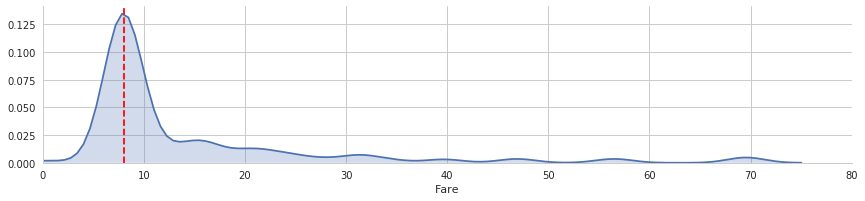

In [15]:
# https://github.com/antonfefilov/titanic
facet = sns.FacetGrid(complete_set[(complete_set["Pclass"] == 3) & (complete_set["Embarked"] == "S")], aspect=4)
facet.map(sns.kdeplot, "Fare", shade=True)
facet.set(xlim=(0, 80))

fare_median = complete_set[(complete_set["Pclass"] == 3) & (complete_set["Embarked"] == "S")]["Fare"].median()
plt.axvline(x=fare_median, color='r', ls='--')
plt.show()

In [16]:
complete_set.loc[complete_set["Fare"].isnull(), "Fare"] = fare_median

Vamos criar a feature _FamilySize_ e visualizar sua relação com a sobrevivência.

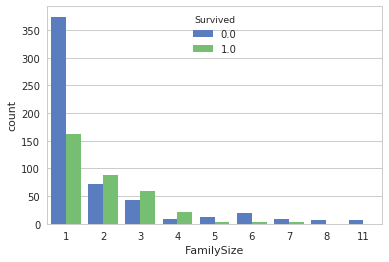

In [17]:
complete_set["FamilySize"] = complete_set["Parch"] + complete_set["SibSp"] + 1

# https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic#do-families-sink-or-swim-together
# https://seaborn.pydata.org/generated/seaborn.countplot.html
g = sns.countplot(x="FamilySize", hue="Survived", data=complete_set[:len(train_set_original)], palette="muted")

Pelo gráfico, vemos que quem estava sozinho tinha mais chances de morrer e quem estava em famílias entre 2 e 4 membros tinha mais chances de sobreviver. Vamos criar uma _feature_ categórica a partir dessa informação.

In [18]:
complete_set["FamilyGroup"] = "single"
complete_set.loc[complete_set["FamilySize"] > 1, "FamilyGroup"] = "small"
complete_set.loc[complete_set["FamilySize"] > 4, "FamilyGroup"] = "large"
complete_set[["FamilySize", "FamilyGroup"]].head(10)

FamilySize FamilyGroup
      PassengerId                        
train 1                     2       small
      2                     2       small
      3                     1      single
      4                     2       small
      5                     1      single
      6                     1      single
      7                     1      single
      8                     5       large
      9                     3       small
      10                    2       small

Agora as pessoas são classificadas como pertencentes a grupos de famílias _single_, _small_ ou _large_.

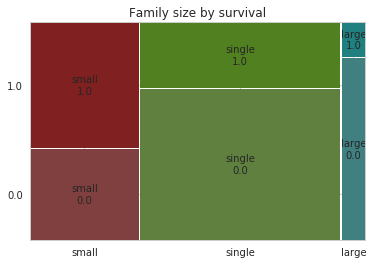

In [19]:
mosaic(complete_set[:len(train_set_original)], ['FamilyGroup', 'Survived'], title="Family size by survival")
plt.show()

Vamos agora, extrair os pronomes usados para cada pessoa.

In [20]:
complete_set["Title"] = complete_set["Name"].apply(lambda s: s[s.index(",") + 2 : s.index(".")])
complete_set.groupby(["Sex", "Title"]).size().unstack(fill_value=0)

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


Retirar o compartilhamento de sexo e pronome:

In [21]:
complete_set.loc[(complete_set["Sex"] == "female") & (complete_set["Title"] == "Dr"), "Title"] = "Mrs"

Unir alguns pronomes femininos.

In [22]:
complete_set["Title"].replace(["Dona", "Lady", "Mlle", "Ms", "Mme", "the Countess"], ["Mrs", "Mrs", "Miss", "Miss", "Mrs", "Mrs"], inplace=True)

Substituindo as poucas ocorrências de títulos pelo título _Special_.

In [23]:
complete_set["Title"].replace(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir'], 'Rare', inplace=True)
complete_set.groupby(["Sex", "Title"]).size().unstack(fill_value=0)

Title,Master,Miss,Mr,Mrs,Rare
Sex,,,,,
female,0,264,0,202,0
male,61,0,757,0,25


In [24]:
train_set = complete_set.loc["train"].copy()
train_set["Survived"] = train_set["Survived"].astype(int)
test_set  = complete_set.loc["test"].copy()
train_set

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,FamilyGroup,Title
PassengerId,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0,A/5 21171,2,small,Mr
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1,PC 17599,2,small,Mrs
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282,1,single,Miss
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1,113803,2,small,Mrs
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0,373450,1,single,Mr
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0,330877,1,single,Mr
7,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,1,male,0,0,17463,1,single,Mr
8,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,0,349909,5,large,Master
9,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1,347742,3,small,Mrs


In [25]:
#train_set.hist(figsize = (8,8))
#plt.show()

In [26]:
mapper = DataFrameMapper([
    ("Title", OneHotEncoder()),
    ("FamilyGroup", OneHotEncoder()),
    ("FamilySize", None),
    ("Fare", None),
    ("Sex", BinaryEncoder()),
    ("Embarked", OneHotEncoder())
], df_out = True)

pipeline = Pipeline([
    ("mapper", mapper),
    ("scaler", StandardScaler()),
    ("estimator", RandomForestRegressor(random_state = 42, n_jobs=4)),
])

pipeline.fit(complete_set[~complete_set["Age"].isnull()], complete_set[~complete_set["Age"].isnull()]["Age"])
age_predicted = pipeline.predict(complete_set[complete_set["Age"].isnull()])
complete_set.loc[complete_set["Age"].isnull(), "Age"] = age_predicted

In [27]:
#colormap = plt.cm.viridis
#plt.figure(figsize=(14,12))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
#sns.heatmap(train_set.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [28]:
#g = sns.pairplot(train_set_encoded[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
#g.set(xticklabels=[])

In [31]:
mapper = DataFrameMapper([
    ("Age", None),
    ("Embarked", OneHotEncoder()),
    ("Fare", None),
    ("Title", OneHotEncoder()),
    ("Parch", None),
    ("Pclass", None),
    ("Sex", BinaryEncoder()),
    ("SibSp", None),
    ("FamilyGroup", OneHotEncoder()),
    ("FamilySize", None),
    ("Title", OneHotEncoder()),
], df_out = False)

pipeline = Pipeline([
    ("mapper", mapper),
    ("imputer", Imputer()),
    #("polynomial", PolynomialFeatures(degree = 2)),
    ("scaler", StandardScaler()),
    #("classifier", RandomForestClassifier(random_state = 42, n_jobs = 4)),
    # not sure about alpha = 1/len(train_set)
    #("classifier", SGDClassifier(loss = "hinge", alpha = 1/len(train_set), max_iter = 1000, random_state = 42, n_jobs = 4)),
    ("classifier", SVC(C=1.0)),
    #("classifier", SVC(kernel = "poly", degree = 2, coef0 = 1, C = 5)), # embedded poly
    #("classifier", SVC(kernel = "rbf", gamma = 5, C = 0.001)),
    #("classifier", AdaBoostClassifier()),
    #("classifier", LinearSVC(C=10, loss = "hinge")),
])

pipeline.fit(train_set, train_set["Survived"])
test_set["Survived"] = pipeline.predict(test_set)
scores = cross_val_score(pipeline, train_set, train_set["Survived"], scoring = "accuracy", cv = 5)
{"Scores": scores, "Mean": scores.mean(), "Standard deviation": scores.std()}

{'Mean': 0.8327896397848491,
 'Scores': array([ 0.84916201,  0.82681564,  0.82022472,  0.80898876,  0.85875706]),
 'Standard deviation': 0.018452149635427635}

In [30]:
test_set["Survived"] = pipeline.predict(test_set)
test_set[["Survived"]].to_csv("result.csv")